**STRUCTURE COMBINING**

In [20]:
f***REMOVED*** rdkit import Chem
f***REMOVED*** rdkit.Chem import RWMol, AllChem, rdMolDescriptors
f***REMOVED*** rdkit.Chem.rdmolfiles import MolsF***REMOVED***CDXMLFile, MolToXYZBlock

def merge_molecules(mol1, mol2, bond_type=Chem.BondType.SINGLE):
    """
    Merges two molecules by removing the 'U' attachment points first and connecting
    the atoms adjacent to them.
    
    :param mol1: First molecule (RDKit Mol)
    :param mol2: Second molecule (RDKit Mol)
    :param bond_type: Type of bond to form (default: SINGLE)
    :return: Merged molecule
    """
    # Convert mol1 to an editable molecule
    combined = Chem.RWMol(mol1)

    # Find attachment points (using 'U' as the placeholder) in both molecules
    u_atoms_1 = [atom for atom in mol1.GetAtoms() if atom.GetSymbol() == "U"]
    u_atoms_2 = [atom for atom in mol2.GetAtoms() if atom.GetSymbol() == "U"]

    if not u_atoms_1 or not u_atoms_2:
        raise ValueError("No U attachment points found in one or both fragments!")

    # Get the atom adjacent to U in each molecule
    atom1_idx = u_atoms_1[0].GetNeighbors()[0].GetIdx()
    atom2_idx = u_atoms_2[0].GetNeighbors()[0].GetIdx()

    # Create an editable copy of mol2
    editable_mol2 = Chem.RWMol(mol2)

    # Remove the U atoms f***REMOVED*** both molecules before merging
    editable_mol2.RemoveAtom(u_atoms_2[0].GetIdx())
    combined.RemoveAtom(u_atoms_1[0].GetIdx())

    # Calculate the offset after removing an atom f***REMOVED*** mol1
    offset = combined.GetNumAtoms()

    # Append atoms f***REMOVED*** mol2 to mol1
    for atom in editable_mol2.GetAtoms():
        combined.AddAtom(atom)

    # Append bonds f***REMOVED*** mol2 to mol1 (adjusting indices by the offset)
    for bond in editable_mol2.GetBonds():
        combined.AddBond(
            bond.GetBeginAtomIdx() + offset,
            bond.GetEndAtomIdx() + offset,
            bond.GetBondType()
        )

    # Add a new bond connecting the attachment points f***REMOVED*** each fragment
    combined.AddBond(atom1_idx, atom2_idx + offset, bond_type)

    return combined.GetMol()

def save_xyz(mol, filename):
    """
    Save the given molecule in .xyz format.
    
    :param mol: RDKit Mol with 3D coordinates
    :param filename: Output filename (should end with .xyz)
    """
    conf = mol.GetConformer()
    num_atoms = mol.GetNumAtoms()
    lines = []
    # First line: number of atoms
    lines.append(str(num_atoms))
    # Second line: comment (we use the molecular formula)
    formula = rdMolDescriptors.CalcMolFormula(mol)
    lines.append(formula)
    # Atom coordinates: element, x, y, z
    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        line = f"{atom.GetSymbol()} {pos.x:.4f} {pos.y:.4f} {pos.z:.4f}"
        lines.append(line)
    # Write to file
    with open(filename, "w") as f:
        f.write("\n".join(lines))

# 📌 Step 1: Read molecules f***REMOVED*** both CDXML files
molecules_1 = [mol for mol in MolsF***REMOVED***CDXMLFile("fragments/ald_subst.cdxml") if mol is not None]
molecules_2 = [mol for mol in MolsF***REMOVED***CDXMLFile("fragments/aniline_all_subst.cdxml") if mol is not None]

#molecules_1 = molecules_1[:10]
#molecules_2 = molecules_2[:2]

# 📌 Step 2: Create merged molecules for all possible combinations
merged_molecules = []
for frag1 in molecules_1:
    for frag2 in molecules_2:
        try:
            merged = merge_molecules(frag1, frag2, Chem.BondType.SINGLE)
            # Compute 2D coordinates for visualization
            AllChem.Compute2DCoords(merged)
            merged_molecules.append(merged)
        except Exception as e:
            print("Failed to merge a pair of fragments:", e)

# 📌 Step 3: Display the generated molecules as SMILES strings
accumulate_smiles = []
for i, mol in enumerate(merged_molecules):
#    print(f"Merged molecule {i}: {Chem.MolToSmiles(mol)}")
    accumulate_smiles.append(Chem.MolToSmiles(mol))
    

# Optionally, draw one or more of the molecules:
f***REMOVED*** rdkit.Chem import Draw
#img = Draw.MolToImage(merged_molecules[0], size=(300, 300))
Draw.MolsToGridImage(merged_molecules, molsPerRow=4, subImgSize=(300, 300))





[11:04:43] WARNING: bond found with ***REMOVED***reo spec but no ***REMOVED***reo atoms
[11:04:43] WARNING: bond found with ***REMOVED***reo spec but no ***REMOVED***reo atoms
[11:04:43] WARNING: bond found with ***REMOVED***reo spec but no ***REMOVED***reo atoms
[11:04:43] WARNING: bond found with ***REMOVED***reo spec but no ***REMOVED***reo atoms
[11:04:43] WARNING: bond found with ***REMOVED***reo spec but no ***REMOVED***reo atoms
[11:04:43] WARNING: bond found with ***REMOVED***reo spec but no ***REMOVED***reo atoms
[11:04:43] WARNING: bond found with ***REMOVED***reo spec but no ***REMOVED***reo atoms
[11:04:43] WARNING: bond found with ***REMOVED***reo spec but no ***REMOVED***reo atoms
[11:04:43] WARNING: bond found with ***REMOVED***reo spec but no ***REMOVED***reo atoms
[11:04:43] WARNING: bond found with ***REMOVED***reo spec but no ***REMOVED***reo atoms
[11:04:43] WARNING: bond found with ***REMOVED***reo spec but no ***REMOVED***reo atoms
[11:04:43] WARNING: bond found w

**CHECK AMOUNT OF STRUCTURES**

In [21]:
len(accumulate_smiles)

385

**(RE)CONVERTING STRUCTURES FROM SMILES TO XYZ**

In [22]:
import os
f***REMOVED*** rdkit import Chem
f***REMOVED*** rdkit.Chem import AllChem
f***REMOVED*** collections import defaultdict

# Dictionary to track file name occurrences
file_name_count = defaultdict(int)

# Function to generate a unique file name
def get_unique_filename(base_name, ext=".xyz"):
    count = file_name_count[base_name]
    if count > 0:
        unique_name = f"{base_name}_{count}{ext}"
    else:
        unique_name = f"{base_name}{ext}"
    file_name_count[base_name] += 1  # Increment counter
    return unique_name

# Loop over all SMILES strings
for smiles in accumulate_smiles:
    mol = Chem.MolF***REMOVED***Smiles(smiles)
    if mol is None:
        print(f"Skipping invalid SMILES: {smiles}")
        continue

    # Add explicit hydrogens
    mol = Chem.AddHs(mol)

    # Generate 3D coordinates
    AllChem.EmbedMolecule(mol, useExpTorsionAnglePrefs=True, useBasicKnowledge=True)
    AllChem.UFFOptimizeMolecule(mol)

    # Get molecular formula
    formula = Chem.rdMolDescriptors.CalcMolFormula(mol)

    # Generate unique file name
    file_name = get_unique_filename(formula)

    # Convert to XYZ format and save
    xyz_block = Chem.MolToXYZBlock(mol)
    with open(file_name, "w") as f:
        f.write(xyz_block)

    print(f"Saved: {file_name}")


Saved: C14H16FN3.xyz
Saved: C13H15FN4.xyz
Saved: C13H13FN2S.xyz
Saved: C12H12FN3S.xyz
Saved: C13H15FN4_1.xyz
Saved: C18H18FN3.xyz
Saved: C17H17FN4.xyz
Saved: C15H19FN4.xyz
Saved: C18H18FN3_1.xyz
Saved: C18H18FN3_2.xyz
Saved: C18H18FN3_3.xyz
Saved: C13H15FN4_2.xyz
Saved: C13H15FN4_3.xyz
Saved: C14H16FN3_1.xyz
Saved: C13H13FN2S_1.xyz
Saved: C12H12FN3S_1.xyz
Saved: C12H12FN3S_2.xyz
Saved: C13H15FN4_4.xyz
Saved: C13H15FN4_5.xyz
Saved: C18H18FN3_4.xyz
Saved: C17H17FN4_1.xyz
Saved: C17H17FN4_2.xyz
Saved: C17H17FN4_3.xyz
Saved: C17H17FN4_4.xyz
Saved: C17H20FN3.xyz
Saved: C16H17FN2O.xyz
Saved: C16H17FN2.xyz
Saved: C15H15FN2.xyz
Saved: C15H14F2N2.xyz
Saved: C15H14ClFN2.xyz
Saved: C15H14BrFN2.xyz
Saved: C15H14FIN2.xyz
Saved: C17H17FN2O2.xyz
Saved: C16H14FN3.xyz
Saved: C15H14FN3O2.xyz
Saved: C13H13FN2O.xyz
Saved: C12H12FN3O.xyz
Saved: C12H10FNOS.xyz
Saved: C11H9FN2OS.xyz
Saved: C12H12FN3O_1.xyz
Saved: C17H15FN2O.xyz
Saved: C16H14FN3O.xyz
Saved: C14H16FN3O.xyz
Saved: C17H15FN2O_1.xyz
Saved: C17H15

**SOLVING NUMBERING PROBLEM**

In [14]:
#reference_smiles = "F/C=N\C"  # cis-F-C=N-C
#reference_smiles = "F/C=N/C"  # trans-F-C=N-C
#reference_smiles = "FC=NC"    # any configuration F-C=N-C

f***REMOVED*** rdkit import Chem
f***REMOVED*** rdkit.Chem import rdmolfiles
f***REMOVED*** rdkit.Chem.rdmolfiles import MolF***REMOVED***XYZFile
f***REMOVED*** rdkit.Chem import rdDetermineBonds

def find_fragment_atoms(xyzfile, reference_smiles):
    """
    Finds and extracts the atom indices of a reference fragment in a molecule f***REMOVED*** an XYZ file.

    Fixes:
    - Uses RDKit's DetermineConnectivity() to assign bonds to XYZ molecules.
    - Sanitizes the molecule to ensure valence is properly assigned.
    
    :param mol: RDKit molecule
    :param reference_fragment: RDKit molecule representing the common fragment
    :return: List of atom indices that match the fragment
    """
    mol = rdmolfiles.MolF***REMOVED***XYZFile(xyzfile)
    rdDetermineBonds.DetermineConnectivity(mol)
    Chem.rdDetermineBonds.DetermineBondOrders(mol)
    Chem.SanitizeMol(mol)
    Chem.Kekulize(mol)
    reference_fragment = Chem.MolF***REMOVED***Smiles(reference_smiles)
    matches = mol.GetSubstructMatches(reference_fragment)
    if not matches:
        raise ValueError("Reference fragment not found in the molecule!")
    return matches[0]  # Return the first match

reference_smiles = "FC=NC"  # Example: Acetate group
match = find_fragment_atoms('unsubst_Z.xyz', reference_smiles)
print(match)

(8, 6, 7, 9)


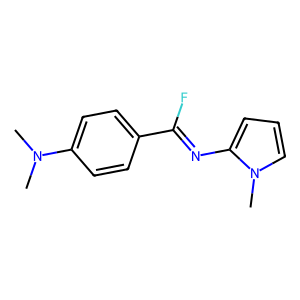

In [15]:
Draw.MolToImage(Chem.MolF***REMOVED***Smiles(accumulate_smiles[0]), size=(300,300))

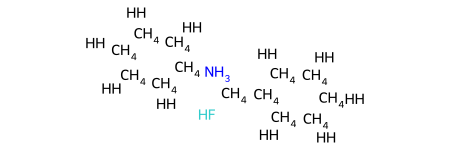

In [23]:
mol = rdmolfiles.MolF***REMOVED***XYZFile('unsubst_Z.xyz')
mol

In [ ]:
rdDetermineBonds.DetermineConnectivity(mol)

Chem.rdDetermineBonds.DetermineBondOrders(mol)
Chem.SanitizeMol(mol)
Chem.Kekulize(mol)
reference_fragment = Chem.MolF***REMOVED***Smiles(reference_smiles)
matches = mol.GetSubstructMatches(reference_fragment)
if not matches:
    raise ValueError("Reference fragment not found in the molecule!")
return matches[0]  # Return the first match

'8,6,7,9'